In [70]:
from pymongo import MongoClient
import pprint

from scipy import stats

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Requests sends and recieves HTTP requests.
import requests

# Beautiful Soup parses HTML documents in python.
from bs4 import BeautifulSoup

import json
import time
import copy

In [71]:
#Import URLs
off_the_tee_url = 'https://www.pgatour.com/content/pgatour/stats/stat.02567.y2019.html'
approach_url = 'https://www.pgatour.com/content/pgatour/stats/stat.02568.y2019.html'
around_the_green_url = 'https://www.pgatour.com/content/pgatour/stats/stat.02569.y2019.html'
putting_url = 'https://www.pgatour.com/content/pgatour/stats/stat.02564.y2019.html'
total_url = 'https://www.pgatour.com/content/pgatour/stats/stat.02675.y2019.html'
scoring_url = 'https://www.pgatour.com/stats/stat.120.y2019.html'

In [72]:
#Request HTML
tee = requests.get(off_the_tee_url)
med_long = requests.get(approach_url)
med_short = requests.get(around_the_green_url)
putt = requests.get(putting_url)
total = requests.get(total_url)
scoring_avg = requests.get(scoring_url)

In [73]:
#Check status == 200 :: 200 implies the request was successfully processed
requested = [tee, med_short, med_long, putt, total,scoring_avg]
for r in requested:
    print(r.status_code)

200
200
200
200
200
200


In [74]:
#Print sample HTML from each request
for r in requested:
    pprint.pprint(r.text[:1000])

('\n'
 '\n'
 '\n'
 '\n'
 '\n'
 '\n'
 '<!DOCTYPE HTML>\n'
 '<html lang="en" >\n'
 '\n'
 '    \n'
 '    \n'
 '        <head>\n'
 '    <meta http-equiv="content-type" content="text/html; charset=UTF-8">\n'
 '    <meta name="viewport" content="width=device-width, initial-scale=1.0, '
 'maximum-scale=1.0, user-scalable=no, shrink-to-fit=no" />\n'
 '\n'
 '    <link rel="canonical" '
 'href="https://www.pgatour.com/stats/stat.02567.y2019.html"/>\n'
 '<meta name="title" content="SG: Off-the-Tee | PGA TOUR Stats" />\n'
 '<meta name="description" content="Strokes Gained | Distance (All Drives) | '
 'Distance (Measured Drives) | Accuracy | Scoring | Other | Radar" />\n'
 '<meta name="msApplication-ID" content="pga-tour/9wzdncrfhz2c"/>\n'
 '\n'
 '<meta name="google-site-verification" '
 'content="xp_dFTcmlaq2Fgq3gyZfIjWo0KjdEC4cfaO4nWx5yPA" />\n'
 '<!-- Google Authorship and Publisher Markup -->\n'
 '<!-- Schema.org markup for Google+ http://schema.org/Article -->\n'
 '<meta itemprop="name" conten

In [75]:
#Save HTML into a MongoDB
client = MongoClient()
golf_db = client.golf
long_html = golf_db.long
med_long_html = golf_db.med_long
med_short_html = golf_db.med_short
short_html = golf_db.short
total_html = golf_db.total
scoring_html = golf_db.scoring

long_html.insert_one({'link': off_the_tee_url, 'html': tee.text})
med_long_html.insert_one({'link': approach_url, 'html': med_long.text})
med_short_html.insert_one({'link': around_the_green_url, 'html': med_short.text})
short_html.insert_one({'link': putting_url, 'html': putt.text})
total_html.insert_one({'link': total_url, 'html': total.text})
scoring_html.insert_one({'link': scoring_url, 'html': scoring_avg.text})
client.list_database_names()

['admin', 'config', 'golf', 'local']

In [76]:
#Parse HTML
soup_tee = BeautifulSoup(tee.text, 'html.parser')
soup_med_long = BeautifulSoup(med_long.text, 'html.parser')
soup_med_short = BeautifulSoup(med_short.text, 'html.parser')
soup_putt = BeautifulSoup(putt.text, 'html.parser')
soup_total = BeautifulSoup(total.text, 'html.parser')
soup_scoreing = BeautifulSoup(scoring_avg.text, 'html.parser')

In [77]:
#Search HTML for table
table_search = soup_tee.find_all('table')
for table in table_search:
    print(table.attrs)

{}
{'class': ['table-styled'], 'id': 'statsTable'}


In [78]:
table_search = soup_med_long.find_all('table')
for table in table_search:
    print(table.attrs)

{}
{'class': ['table-styled'], 'id': 'statsTable'}


In [79]:
table_search = soup_med_short.find_all('table')
for table in table_search:
    print(table.attrs)

{}
{'class': ['table-styled'], 'id': 'statsTable'}


In [80]:
table_search = soup_putt.find_all('table')
for table in table_search:
    print(table.attrs)

{}
{'class': ['table-styled'], 'id': 'statsTable'}


In [81]:
table_search = soup_total.find_all('table')
for table in table_search:
    print(table.attrs)

{}
{'class': ['table-styled'], 'id': 'statsTable'}


In [82]:
table_search = soup_scoreing.find_all('table')
for table in table_search:
    print(table.attrs)

{}
{'class': ['table-styled'], 'id': 'statsTable'}


In [83]:
#All tables have class attribute 'table-styled'
#Functionalize getting data from each
def get_list_from_soup(soup_object):
    data = []
    table = soup_object.find('table', attrs={'class':'table-styled'})
    table_body = table.find('tbody')

    rows = table_body.find_all('tr')
    for row in rows:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols]
        data.append([ele for ele in cols if ele])
        
    return data

In [84]:
#Plug soup objects into function above
tee_data = get_list_from_soup(soup_tee)
approach_data = get_list_from_soup(soup_med_long)
chip_data = get_list_from_soup(soup_med_short)
putt_data = get_list_from_soup(soup_putt)
total_data = get_list_from_soup(soup_total)
scoring_data = get_list_from_soup(soup_scoreing)

In [85]:
print (tee_data[:5])
print()
print (tee_data[-5:-1])

[['1', '1', 'Rory McIlroy', '72', '1.195', '68.124', '57'], ['2', '3', 'Jhonattan Vegas', '75', '.753', '45.956', '61'], ['3', '4', 'Bubba Watson', '65', '.743', '37.171', '50'], ['4', '5', 'Dustin Johnson', '73', '.703', '39.360', '56'], ['5', '2', 'Jon Rahm', '75', '.692', '36.684', '53']]

[['T184', 'T188', 'Andrew Putnam', '81', '-.639', '-35.778', '56'], ['T184', 'T188', 'Freddie Jacobson', '53', '-.639', '-25.559', '40'], ['186', '190', 'Jonathan Byrd', '55', '-.758', '-27.300', '36'], ['187', '191', 'Whee Kim', '73', '-1.035', '-48.665', '47']]


In [86]:
approach_data

[['1', '1', 'Henrik Stenson', '58', '1.149', '48.250', '42'],
 ['2', '2', 'Justin Thomas', '75', '.985', '55.176', '56'],
 ['3', '3', 'Emiliano Grillo', '85', '.926', '50.929', '55'],
 ['4', '4', 'Adam Scott', '63', '.846', '37.234', '44'],
 ['5', '5', 'Hideki Matsuyama', '91', '.759', '55.397', '73'],
 ['6', '7', 'Jason Kokrak', '94', '.745', '55.838', '75'],
 ['7', '6', 'Jim Furyk', '73', '.741', '42.250', '57'],
 ['8', '9', 'Paul Casey', '79', '.706', '38.844', '55'],
 ['9', '10', 'Corey Conners', '90', '.665', '45.915', '69'],
 ['10', '12', 'Patrick Cantlay', '77', '.640', '36.474', '57'],
 ['11', '16', 'Brooks Koepka', '81', '.636', '36.896', '58'],
 ['12', '13', 'Rory McIlroy', '72', '.633', '36.096', '57'],
 ['13', '17', 'Chez Reavie', '99', '.625', '43.753', '70'],
 ['14', '11', 'Webb Simpson', '81', '.613', '42.285', '69'],
 ['15', '14', 'Talor Gooch', '54', '.604', '28.977', '48'],
 ['16', '15', 'Ryan Moore', '74', '.596', '37.519', '63'],
 ['17', '8', 'Matt Kuchar', '87', '.

In [87]:
chip_data

[['1', '1', 'Byeong Hun An', '80', '.631', '38.504', '61'],
 ['2', '2', 'Bud Cauley', '82', '.577', '42.673', '74'],
 ['3', '3', 'Brandt Snedeker', '102', '.480', '38.408', '80'],
 ['4', '4', 'Aaron Baddeley', '55', '.460', '19.309', '42'],
 ['5', '8', 'Stephan Jaeger', '77', '.365', '20.783', '57'],
 ['6', '6', 'Patrick Cantlay', '77', '.356', '20.291', '57'],
 ['7', '10', 'Kevin Na', '65', '.355', '15.617', '44'],
 ['T8', '11', 'Matt Jones', '88', '.352', '23.225', '66'],
 ['T8', 'T19', 'Justin Thomas', '75', '.352', '19.729', '56'],
 ['10', '5', 'Adam Scott', '63', '.351', '15.457', '44'],
 ['11', '12', 'Bill Haas', '77', '.350', '21.342', '61'],
 ['12', '13', 'Hideki Matsuyama', '91', '.347', '25.337', '73'],
 ['13', '14', 'Pat Perez', '68', '.335', '13.736', '41'],
 ['14', '15', 'Patrick Reed', '93', '.332', '24.253', '73'],
 ['15', 'T19', 'Tommy Fleetwood', '71', '.329', '16.466', '50'],
 ['16', '7', 'Charles Howell III', '94', '.328', '23.940', '73'],
 ['17', '17', 'Jimmy Walker

In [88]:
putt_data

[['1', '1', 'Denny McCarthy', '89', '.926', '63.890', '69'],
 ['2', '2', 'Jordan Spieth', '82', '.862', '56.900', '66'],
 ['3', '3', 'Dominic Bozzelli', '73', '.847', '41.522', '49'],
 ['4', '4', 'Graeme McDowell', '75', '.731', '36.555', '50'],
 ['5', '5', 'Andrew Putnam', '81', '.700', '39.180', '56'],
 ['6', '8', 'Aaron Baddeley', '55', '.654', '27.451', '42'],
 ['7', '9', 'Patton Kizzire', '76', '.642', '34.050', '53'],
 ['8', '10', 'Wyndham Clark', '87', '.640', '46.752', '73'],
 ['9', '11', 'Vaughn Taylor', '93', '.636', '52.113', '82'],
 ['10', '12', 'Beau Hossler', '87', '.619', '42.084', '68'],
 ['11', '13', 'Webb Simpson', '81', '.608', '41.957', '69'],
 ['12', '6', 'Brandt Snedeker', '102', '.592', '47.330', '80'],
 ['13', '18', 'Rickie Fowler', '76', '.541', '34.066', '63'],
 ['14', '15', 'Pat Perez', '68', '.535', '21.954', '41'],
 ['15', '16', 'Harris English', '97', '.527', '41.671', '79'],
 ['16', '17', 'Billy Horschel', '99', '.522', '36.051', '69'],
 ['17', '7', 'Just

In [89]:
total_data

[['1',
  '1',
  'Rory McIlroy',
  '72',
  '2.551',
  '145.379',
  '121.159',
  '24.221',
  '57'],
 ['2',
  '2',
  'Patrick Cantlay',
  '77',
  '1.857',
  '105.858',
  '83.833',
  '22.027',
  '57'],
 ['3', '3', 'Adam Scott', '63', '1.831', '80.569', '65.250', '15.321', '44'],
 ['4',
  '4',
  'Justin Thomas',
  '75',
  '1.631',
  '91.314',
  '101.736',
  '-10.419',
  '56'],
 ['5',
  '6',
  'Webb Simpson',
  '81',
  '1.507',
  '104.007',
  '62.051',
  '41.957',
  '69'],
 ['6', '7', 'Jon Rahm', '75', '1.505', '79.788', '61.994', '17.793', '53'],
 ['7',
  '8',
  'Hideki Matsuyama',
  '91',
  '1.498',
  '109.340',
  '108.527',
  '.811',
  '73'],
 ['8',
  '13',
  'Xander Schauffele',
  '77',
  '1.393',
  '73.836',
  '60.887',
  '12.949',
  '53'],
 ['9',
  '11',
  'Brooks Koepka',
  '81',
  '1.366',
  '79.205',
  '66.101',
  '13.106',
  '58'],
 ['10', '12', 'Paul Casey', '79', '1.361', '74.878', '79.936', '-5.058', '55'],
 ['11',
  '5',
  'Dustin Johnson',
  '73',
  '1.321',
  '73.995',
  '68.

In [90]:
scoring_data

[['1', '2', 'Rory McIlroy', '72', '69.057', '4,695', '.846', '68'],
 ['2', '1', 'Patrick Cantlay', '77', '69.306', '4,980', '10.057', '72'],
 ['3', '3', 'Webb Simpson', '81', '69.377', '5,392', '19.390', '78'],
 ['4', '4', 'Brooks Koepka', '81', '69.395', '5,121', '14.220', '74'],
 ['5', '5', 'Justin Thomas', '75', '69.466', '4,967', '34.532', '72'],
 ['6', '6', 'Jon Rahm', '75', '69.618', '4,720', '14.042', '68'],
 ['7', '10', 'Adam Scott', '63', '69.693', '4,252', '- .715', '61'],
 ['8', '8', 'Tommy Fleetwood', '71', '69.729', '4,472', '- 9.317', '64'],
 ['9', '13', 'Paul Casey', '79', '69.821', '5,225', '11.580', '75'],
 ['10', '9', 'Justin Rose', '66', '69.825', '4,334', '- 4.841', '62'],
 ['11', '15', 'Xander Schauffele', '77', '69.834', '5,154', '13.704', '74'],
 ['12', '11', 'Hideki Matsuyama', '91', '69.841', '6,118', '28.001', '88'],
 ['13', '7', 'Dustin Johnson', '73', '69.895', '4,892', '.616', '70'],
 ['14', '12', 'Matt Kuchar', '87', '69.916', '5,564', '29.300', '80'],
 ['

In [91]:
tee_trimmed = [[x[0], x[2], x[4]] for x in tee_data]
approach_trimmed = [[x[0], x[2], x[4]] for x in approach_data]
chip_trimmed = [[x[0], x[2], x[4]] for x in chip_data]
putt_trimmed = [[x[0], x[2], x[4]] for x in putt_data]
scoring_trimmed = [[x[2], x[4]] for x in scoring_data]

In [92]:
tee_trimmed

[['1', 'Rory McIlroy', '1.195'],
 ['2', 'Jhonattan Vegas', '.753'],
 ['3', 'Bubba Watson', '.743'],
 ['4', 'Dustin Johnson', '.703'],
 ['5', 'Jon Rahm', '.692'],
 ['T6', 'Keith Mitchell', '.657'],
 ['T6', 'Cameron Champ', '.657'],
 ['8', 'Corey Conners', '.653'],
 ['9', 'Paul Casey', '.614'],
 ['10', 'Abraham Ancer', '.575'],
 ['11', 'Jason Kokrak', '.550'],
 ['12', 'Tommy Fleetwood', '.545'],
 ['13', 'Jason Day', '.535'],
 ['14', 'Aaron Wise', '.533'],
 ['15', 'Brendan Steele', '.518'],
 ['16', 'Luke List', '.481'],
 ['17', 'Justin Thomas', '.479'],
 ['18', 'Patrick Cantlay', '.475'],
 ['19', 'Gary Woodland', '.472'],
 ['20', 'Emiliano Grillo', '.470'],
 ['21', 'Brooks Koepka', '.468'],
 ['22', 'Xander Schauffele', '.456'],
 ['23', 'Tony Finau', '.439'],
 ['24', 'Bryson DeChambeau', '.421'],
 ['25', 'Kevin Streelman', '.383'],
 ['26', 'Hideki Matsuyama', '.381'],
 ['27', 'Alex Prugh', '.379'],
 ['28', 'Sepp Straka', '.378'],
 ['29', 'Byeong Hun An', '.351'],
 ['30', 'Sergio Garcia', '

In [93]:
approach_trimmed

[['1', 'Henrik Stenson', '1.149'],
 ['2', 'Justin Thomas', '.985'],
 ['3', 'Emiliano Grillo', '.926'],
 ['4', 'Adam Scott', '.846'],
 ['5', 'Hideki Matsuyama', '.759'],
 ['6', 'Jason Kokrak', '.745'],
 ['7', 'Jim Furyk', '.741'],
 ['8', 'Paul Casey', '.706'],
 ['9', 'Corey Conners', '.665'],
 ['10', 'Patrick Cantlay', '.640'],
 ['11', 'Brooks Koepka', '.636'],
 ['12', 'Rory McIlroy', '.633'],
 ['13', 'Chez Reavie', '.625'],
 ['14', 'Webb Simpson', '.613'],
 ['15', 'Talor Gooch', '.604'],
 ['16', 'Ryan Moore', '.596'],
 ['17', 'Matt Kuchar', '.591'],
 ['18', 'Russell Knox', '.585'],
 ['19', 'Keegan Bradley', '.567'],
 ['20', 'Gary Woodland', '.545'],
 ['T21', 'Sergio Garcia', '.525'],
 ['T21', 'Justin Rose', '.525'],
 ['23', 'Adam Svensson', '.509'],
 ['24', 'Nate Lashley', '.487'],
 ['25', 'Joaquin Niemann', '.484'],
 ['26', 'Xander Schauffele', '.481'],
 ['27', 'Kevin Streelman', '.479'],
 ['28', 'Marc Leishman', '.472'],
 ['29', 'Roberto Castro', '.432'],
 ['30', 'Shawn Stefani', '.4

In [94]:
chip_trimmed

[['1', 'Byeong Hun An', '.631'],
 ['2', 'Bud Cauley', '.577'],
 ['3', 'Brandt Snedeker', '.480'],
 ['4', 'Aaron Baddeley', '.460'],
 ['5', 'Stephan Jaeger', '.365'],
 ['6', 'Patrick Cantlay', '.356'],
 ['7', 'Kevin Na', '.355'],
 ['T8', 'Matt Jones', '.352'],
 ['T8', 'Justin Thomas', '.352'],
 ['10', 'Adam Scott', '.351'],
 ['11', 'Bill Haas', '.350'],
 ['12', 'Hideki Matsuyama', '.347'],
 ['13', 'Pat Perez', '.335'],
 ['14', 'Patrick Reed', '.332'],
 ['15', 'Tommy Fleetwood', '.329'],
 ['16', 'Charles Howell III', '.328'],
 ['17', 'Jimmy Walker', '.322'],
 ['18', 'Si Woo Kim', '.305'],
 ['19', 'Rory McIlroy', '.297'],
 ['20', 'Webb Simpson', '.294'],
 ['T21', 'Tyrrell Hatton', '.286'],
 ['T21', 'Cameron Smith', '.286'],
 ['23', 'Sungjae Im', '.285'],
 ['24', 'Ernie Els', '.282'],
 ['25', 'Alex Noren', '.280'],
 ['T26', 'Rod Pampling', '.278'],
 ['T26', 'Branden Grace', '.278'],
 ['28', 'Louis Oosthuizen', '.270'],
 ['29', 'Ian Poulter', '.267'],
 ['30', 'Rory Sabbatini', '.263'],
 ['T

In [95]:
putt_trimmed

[['1', 'Denny McCarthy', '.926'],
 ['2', 'Jordan Spieth', '.862'],
 ['3', 'Dominic Bozzelli', '.847'],
 ['4', 'Graeme McDowell', '.731'],
 ['5', 'Andrew Putnam', '.700'],
 ['6', 'Aaron Baddeley', '.654'],
 ['7', 'Patton Kizzire', '.642'],
 ['8', 'Wyndham Clark', '.640'],
 ['9', 'Vaughn Taylor', '.636'],
 ['10', 'Beau Hossler', '.619'],
 ['11', 'Webb Simpson', '.608'],
 ['12', 'Brandt Snedeker', '.592'],
 ['13', 'Rickie Fowler', '.541'],
 ['14', 'Pat Perez', '.535'],
 ['15', 'Harris English', '.527'],
 ['16', 'Billy Horschel', '.522'],
 ['17', 'Justin Rose', '.504'],
 ['18', 'Johnson Wagner', '.488'],
 ['19', 'Peter Malnati', '.467'],
 ['20', 'Kevin Kisner', '.450'],
 ['21', 'Curtis Luck', '.446'],
 ['22', 'Patrick Rodgers', '.428'],
 ['23', 'Sam Ryder', '.427'],
 ['T24', 'Rory McIlroy', '.425'],
 ['T24', 'Ian Poulter', '.425'],
 ['26', 'Patrick Cantlay', '.386'],
 ['27', 'Chase Wright', '.379'],
 ['28', 'Bryson DeChambeau', '.372'],
 ['29', 'Sam Burns', '.369'],
 ['30', 'Jason Day', '.

In [96]:
scoring_trimmed

[['Rory McIlroy', '69.057'],
 ['Patrick Cantlay', '69.306'],
 ['Webb Simpson', '69.377'],
 ['Brooks Koepka', '69.395'],
 ['Justin Thomas', '69.466'],
 ['Jon Rahm', '69.618'],
 ['Adam Scott', '69.693'],
 ['Tommy Fleetwood', '69.729'],
 ['Paul Casey', '69.821'],
 ['Justin Rose', '69.825'],
 ['Xander Schauffele', '69.834'],
 ['Hideki Matsuyama', '69.841'],
 ['Dustin Johnson', '69.895'],
 ['Matt Kuchar', '69.916'],
 ['Tony Finau', '69.955'],
 ['Rickie Fowler', '69.955'],
 ['Lucas Glover', '70.083'],
 ['Henrik Stenson', '70.089'],
 ['Jim Furyk', '70.090'],
 ['Bryson DeChambeau', '70.177'],
 ['Patrick Reed', '70.208'],
 ['Jason Day', '70.212'],
 ['Gary Woodland', '70.229'],
 ['Chez Reavie', '70.247'],
 ['Sungjae Im', '70.252'],
 ['Louis Oosthuizen', '70.259'],
 ['Sergio Garcia', '70.321'],
 ['Scott Piercy', '70.333'],
 ['Rory Sabbatini', '70.409'],
 ['Kevin Kisner', '70.416'],
 ['Jason Kokrak', '70.431'],
 ['Marc Leishman', '70.434'],
 ['Daniel Berger', '70.443'],
 ['Vaughn Taylor', '70.450'

In [97]:
print(f'{len(tee_trimmed)} values in tee')
print(f'{len(approach_trimmed)} values in approach')
print(f'{len(chip_trimmed)} values in chip')
print(f'{len(putt_trimmed)} values in putt')

188 values in tee
188 values in approach
188 values in chip
188 values in putt


In [98]:
tee_df = pd.DataFrame(tee_trimmed, columns = ['tee_rank', 'name', 'tee_strokes_gained'])
tee_df

,tee_rank,name,tee_strokes_gained
0,1,Rory McIlroy,1.195
1,2,Jhonattan Vegas,.753
2,3,Bubba Watson,.743
3,4,Dustin Johnson,.703
4,5,Jon Rahm,.692
...,...,...,...
183,T184,Andrew Putnam,-.639
184,T184,Freddie Jacobson,-.639
185,186,Jonathan Byrd,-.758
186,187,Whee Kim,-1.035


In [99]:
approach_df = pd.DataFrame(approach_trimmed, columns = ['approach_rank', 'name', 'approach_strokes_gained'])
approach_df

,approach_rank,name,approach_strokes_gained
0,1,Henrik Stenson,1.149
1,2,Justin Thomas,.985
2,3,Emiliano Grillo,.926
3,4,Adam Scott,.846
4,5,Hideki Matsuyama,.759
...,...,...,...
183,184,Beau Hossler,-.765
184,185,Dominic Bozzelli,-.766
185,186,Curtis Luck,-.847
186,187,Seth Reeves,-.941


In [100]:
chip_df = pd.DataFrame(chip_trimmed, columns = ['chip_rank', 'name', 'chip_strokes_gained'])
chip_df

,chip_rank,name,chip_strokes_gained
0,1,Byeong Hun An,.631
1,2,Bud Cauley,.577
2,3,Brandt Snedeker,.480
3,4,Aaron Baddeley,.460
4,5,Stephan Jaeger,.365
...,...,...,...
183,T183,Seth Reeves,-.366
184,185,Austin Cook,-.372
185,186,Satoshi Kodaira,-.414
186,187,Hunter Mahan,-.574


In [101]:
putt_df = pd.DataFrame(putt_trimmed, columns = ['putt_rank', 'name', 'putt_strokes_gained'])
putt_df

,putt_rank,name,putt_strokes_gained
0,1,Denny McCarthy,.926
1,2,Jordan Spieth,.862
2,3,Dominic Bozzelli,.847
3,4,Graeme McDowell,.731
4,5,Andrew Putnam,.700
...,...,...,...
183,184,Kramer Hickok,-.604
184,185,Emiliano Grillo,-.633
185,186,J.J. Henry,-.657
186,187,J.B. Holmes,-.752


In [102]:
scoring_df = pd.DataFrame(scoring_trimmed, columns = ['name', 'scoring_average'])
scoring_df

,name,scoring_average
0,Rory McIlroy,69.057
1,Patrick Cantlay,69.306
2,Webb Simpson,69.377
3,Brooks Koepka,69.395
4,Justin Thomas,69.466
...,...,...
183,Martin Trainer,72.343
184,Whee Kim,72.474
185,John Chin,72.485
186,Satoshi Kodaira,72.780


In [103]:
#Merge DataFrames
golf_df = pd.merge(tee_df, approach_df, how = 'left', on = 'name')
golf_df = pd.merge(golf_df, chip_df, how = 'left', on = 'name')
golf_df = pd.merge(golf_df, putt_df, how = 'left', on = 'name')
golf_df = pd.merge(golf_df, scoring_df, how = 'left', on = 'name')
golf_df

,tee_rank,name,tee_strokes_gained,approach_rank,approach_strokes_gained,chip_rank,chip_strokes_gained,putt_rank,putt_strokes_gained,scoring_average
0,1,Rory McIlroy,1.195,12,.633,19,.297,T24,.425,69.057
1,2,Jhonattan Vegas,.753,60,.219,154,-.190,135,-.156,70.765
2,3,Bubba Watson,.743,120,-.052,124,-.067,T167,-.344,70.710
3,4,Dustin Johnson,.703,47,.288,38,.234,74,.096,69.895
4,5,Jon Rahm,.692,34,.405,78,.073,36,.336,69.618
...,...,...,...,...,...,...,...,...,...,...
183,T184,Andrew Putnam,-.639,32,.414,83,.061,5,.700,70.644
184,T184,Freddie Jacobson,-.639,138,-.151,152,-.178,64,.142,71.953
185,186,Jonathan Byrd,-.758,63,.204,41,.205,171,-.412,71.490
186,187,Whee Kim,-1.035,146,-.217,T129,-.080,92,.042,72.474


In [104]:
#Rearrange columns
cols = golf_df.columns.tolist()
cols = [cols[1],cols[0]] + cols[2:]
golf_df = golf_df[cols]
golf_df

,name,tee_rank,tee_strokes_gained,approach_rank,approach_strokes_gained,chip_rank,chip_strokes_gained,putt_rank,putt_strokes_gained,scoring_average
0,Rory McIlroy,1,1.195,12,.633,19,.297,T24,.425,69.057
1,Jhonattan Vegas,2,.753,60,.219,154,-.190,135,-.156,70.765
2,Bubba Watson,3,.743,120,-.052,124,-.067,T167,-.344,70.710
3,Dustin Johnson,4,.703,47,.288,38,.234,74,.096,69.895
4,Jon Rahm,5,.692,34,.405,78,.073,36,.336,69.618
...,...,...,...,...,...,...,...,...,...,...
183,Andrew Putnam,T184,-.639,32,.414,83,.061,5,.700,70.644
184,Freddie Jacobson,T184,-.639,138,-.151,152,-.178,64,.142,71.953
185,Jonathan Byrd,186,-.758,63,.204,41,.205,171,-.412,71.490
186,Whee Kim,187,-1.035,146,-.217,T129,-.080,92,.042,72.474


In [105]:
golf_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188 entries, 0 to 187
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   name                     188 non-null    object
 1   tee_rank                 188 non-null    object
 2   tee_strokes_gained       188 non-null    object
 3   approach_rank            188 non-null    object
 4   approach_strokes_gained  188 non-null    object
 5   chip_rank                188 non-null    object
 6   chip_strokes_gained      188 non-null    object
 7   putt_rank                188 non-null    object
 8   putt_strokes_gained      188 non-null    object
 9   scoring_average          188 non-null    object
dtypes: object(10)
memory usage: 16.2+ KB


In [106]:
#Strip rankings of T in ties
rankings = ['tee_rank', 'approach_rank', 'chip_rank', 'putt_rank']
for series in rankings:
    for string in series:
        golf_df[series] = golf_df[series].str.replace('T','')

In [107]:
golf_df

,name,tee_rank,tee_strokes_gained,approach_rank,approach_strokes_gained,chip_rank,chip_strokes_gained,putt_rank,putt_strokes_gained,scoring_average
0,Rory McIlroy,1,1.195,12,.633,19,.297,24,.425,69.057
1,Jhonattan Vegas,2,.753,60,.219,154,-.190,135,-.156,70.765
2,Bubba Watson,3,.743,120,-.052,124,-.067,167,-.344,70.710
3,Dustin Johnson,4,.703,47,.288,38,.234,74,.096,69.895
4,Jon Rahm,5,.692,34,.405,78,.073,36,.336,69.618
...,...,...,...,...,...,...,...,...,...,...
183,Andrew Putnam,184,-.639,32,.414,83,.061,5,.700,70.644
184,Freddie Jacobson,184,-.639,138,-.151,152,-.178,64,.142,71.953
185,Jonathan Byrd,186,-.758,63,.204,41,.205,171,-.412,71.490
186,Whee Kim,187,-1.035,146,-.217,129,-.080,92,.042,72.474


In [108]:
columns_sans_name = golf_df.columns.tolist()[1:]
for col in columns_sans_name:
    golf_df[col] = pd.to_numeric(golf_df[col])
golf_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188 entries, 0 to 187
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   name                     188 non-null    object 
 1   tee_rank                 188 non-null    int64  
 2   tee_strokes_gained       188 non-null    float64
 3   approach_rank            188 non-null    int64  
 4   approach_strokes_gained  188 non-null    float64
 5   chip_rank                188 non-null    int64  
 6   chip_strokes_gained      188 non-null    float64
 7   putt_rank                188 non-null    int64  
 8   putt_strokes_gained      188 non-null    float64
 9   scoring_average          188 non-null    float64
dtypes: float64(5), int64(4), object(1)
memory usage: 16.2+ KB


In [109]:
bins = 187 ** .5
print(bins)



13.674794331177344


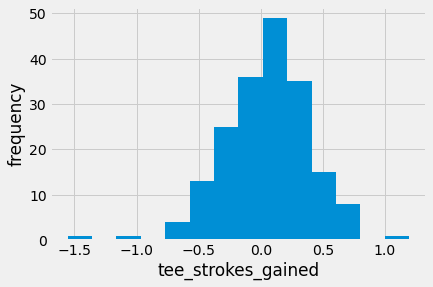

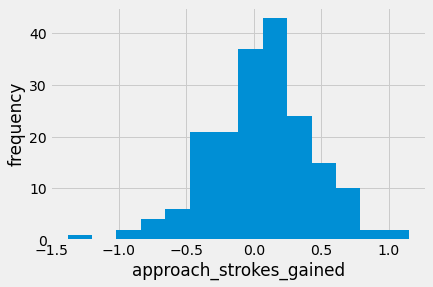

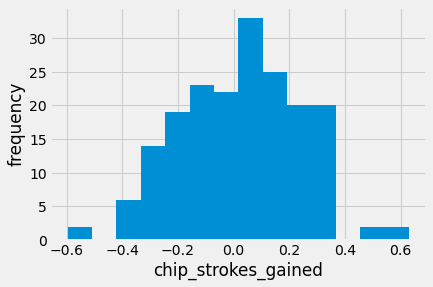

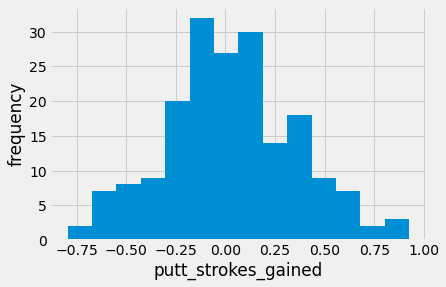

In [110]:
strokes_gained_columns = [golf_df.tee_strokes_gained, golf_df.approach_strokes_gained, golf_df.chip_strokes_gained, golf_df.putt_strokes_gained]

for series in strokes_gained_columns:
    fig, ax = plt.subplots()
    ax.hist(series, 14)
    ax.set_xlabel(series.name)
    ax.set_ylabel('frequency')

In [111]:
temp = golf_df.copy()
temp['LONG_STROKES_GAINED'] = (temp['tee_strokes_gained'] + temp['approach_strokes_gained']) /2
long_game_sorted = temp.sort_values('LONG_STROKES_GAINED', ascending = False)
long_game_sorted['LONG_GAME_RANK'] = long_game_sorted['LONG_STROKES_GAINED'].rank( ascending = False)

In [112]:
tempo = golf_df.copy()
tempo['SHORT_STROKES_GAINED'] = (tempo['chip_strokes_gained'] + tempo['putt_strokes_gained'])/2
short_game_sorted = tempo.sort_values('SHORT_STROKES_GAINED', ascending = False)
short_game_sorted['SHORT_GAME_RANK'] = short_game_sorted['SHORT_STROKES_GAINED'].rank(ascending = False)

In [113]:
golf_df['LONG_GAME_RANK'] = long_game_sorted['LONG_GAME_RANK']
golf_df['LONG_STROKES_GAINED'] = long_game_sorted['LONG_STROKES_GAINED']
golf_df['SHORT_GAME_RANK'] = short_game_sorted['SHORT_GAME_RANK']
golf_df['SHORT_STROKES_GAINED'] = short_game_sorted['SHORT_STROKES_GAINED']
golf_df

,name,tee_rank,tee_strokes_gained,approach_rank,approach_strokes_gained,chip_rank,chip_strokes_gained,putt_rank,putt_strokes_gained,scoring_average,LONG_GAME_RANK,LONG_STROKES_GAINED,SHORT_GAME_RANK,SHORT_STROKES_GAINED
0,Rory McIlroy,1,1.195,12,0.633,19,0.297,24,0.425,69.057,1.0,0.9140,12.0,0.3610
1,Jhonattan Vegas,2,0.753,60,0.219,154,-0.190,135,-0.156,70.765,14.0,0.4860,152.0,-0.1730
2,Bubba Watson,3,0.743,120,-0.052,124,-0.067,167,-0.344,70.710,30.0,0.3455,162.0,-0.2055
3,Dustin Johnson,4,0.703,47,0.288,38,0.234,74,0.096,69.895,13.0,0.4955,50.0,0.1650
4,Jon Rahm,5,0.692,34,0.405,78,0.073,36,0.336,69.618,11.0,0.5485,39.0,0.2045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,Andrew Putnam,184,-0.639,32,0.414,83,0.061,5,0.700,70.644,138.0,-0.1125,10.0,0.3805
184,Freddie Jacobson,184,-0.639,138,-0.151,152,-0.178,64,0.142,71.953,177.0,-0.3950,110.0,-0.0180
185,Jonathan Byrd,186,-0.758,63,0.204,41,0.205,171,-0.412,71.490,162.0,-0.2770,138.0,-0.1035
186,Whee Kim,187,-1.035,146,-0.217,129,-0.080,92,0.042,72.474,185.0,-0.6260,111.0,-0.0190


Text(0, 0.5, 'frequency')

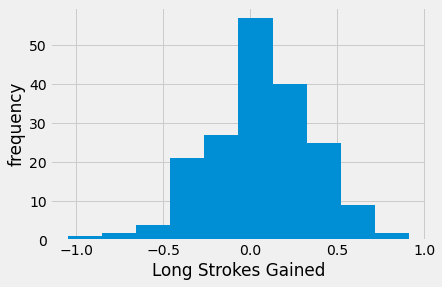

In [114]:
fig, ax = plt.subplots()
ax.hist(golf_df['LONG_STROKES_GAINED'])
ax.set_xlabel('Long Strokes Gained')
ax.set_ylabel('frequency')

Text(0, 0.5, 'frequency')

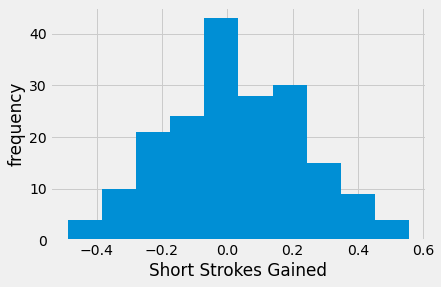

In [115]:
fig, ax = plt.subplots()
ax.hist(golf_df['SHORT_STROKES_GAINED'])
ax.set_xlabel('Short Strokes Gained')
ax.set_ylabel('frequency')

In [116]:
short_game_bool = golf_df['SHORT_STROKES_GAINED'] > 0
short_gamers = golf_df[short_game_bool]
short_gamers

,name,tee_rank,tee_strokes_gained,approach_rank,approach_strokes_gained,chip_rank,chip_strokes_gained,putt_rank,putt_strokes_gained,scoring_average,LONG_GAME_RANK,LONG_STROKES_GAINED,SHORT_GAME_RANK,SHORT_STROKES_GAINED
0,Rory McIlroy,1,1.195,12,0.633,19,0.297,24,0.425,69.057,1.0,0.9140,12.0,0.3610
3,Dustin Johnson,4,0.703,47,0.288,38,0.234,74,0.096,69.895,13.0,0.4955,50.0,0.1650
4,Jon Rahm,5,0.692,34,0.405,78,0.073,36,0.336,69.618,11.0,0.5485,39.0,0.2045
8,Paul Casey,9,0.614,8,0.706,56,0.133,121,-0.092,69.821,4.0,0.6600,93.0,0.0205
11,Tommy Fleetwood,12,0.545,55,0.235,15,0.329,55,0.169,69.729,23.0,0.3900,28.0,0.2490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,Pat Perez,180,-0.498,129,-0.085,13,0.335,14,0.535,71.059,164.0,-0.2915,7.0,0.4350
180,Curtis Luck,181,-0.546,186,-0.847,147,-0.157,21,0.446,72.001,186.0,-0.6965,56.0,0.1445
181,Chris Stroud,182,-0.557,147,-0.229,94,0.035,94,0.022,71.644,176.0,-0.3930,89.0,0.0285
182,Scott Langley,183,-0.593,176,-0.483,47,0.179,65,0.130,71.605,184.0,-0.5380,52.5,0.1545


In [117]:
long_game_bool = golf_df['LONG_STROKES_GAINED'] > 0
long_gamers = golf_df[long_game_bool]
long_gamers

,name,tee_rank,tee_strokes_gained,approach_rank,approach_strokes_gained,chip_rank,chip_strokes_gained,putt_rank,putt_strokes_gained,scoring_average,LONG_GAME_RANK,LONG_STROKES_GAINED,SHORT_GAME_RANK,SHORT_STROKES_GAINED
0,Rory McIlroy,1,1.195,12,0.633,19,0.297,24,0.425,69.057,1.0,0.9140,12.0,0.3610
1,Jhonattan Vegas,2,0.753,60,0.219,154,-0.190,135,-0.156,70.765,14.0,0.4860,152.0,-0.1730
2,Bubba Watson,3,0.743,120,-0.052,124,-0.067,167,-0.344,70.710,30.0,0.3455,162.0,-0.2055
3,Dustin Johnson,4,0.703,47,0.288,38,0.234,74,0.096,69.895,13.0,0.4955,50.0,0.1650
4,Jon Rahm,5,0.692,34,0.405,78,0.073,36,0.336,69.618,11.0,0.5485,39.0,0.2045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,Talor Gooch,153,-0.240,15,0.604,133,-0.104,70,0.111,70.629,61.0,0.1820,100.0,0.0035
153,Nate Lashley,154,-0.247,24,0.487,117,-0.021,40,0.304,70.692,79.0,0.1200,57.0,0.1415
162,Henrik Stenson,163,-0.293,1,1.149,106,0.010,71,0.106,70.089,19.0,0.4280,84.0,0.0580
163,Shawn Stefani,164,-0.303,30,0.421,56,0.133,138,-0.159,70.958,93.0,0.0590,108.0,-0.0130


Text(0, 0.5, 'frequency')

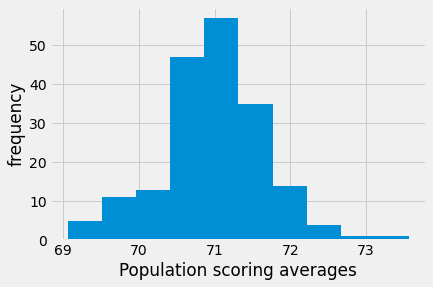

In [118]:
fig, ax = plt.subplots()
ax.hist(golf_df['scoring_average'])
ax.set_xlabel('Population scoring averages')
ax.set_ylabel('frequency')

In [119]:
long_gamers_scoring = long_gamers['scoring_average']
short_gamers_scoring = short_gamers['scoring_average']
long_game_mean = long_gamers_scoring.mean()
short_game_mean = short_gamers_scoring.mean()

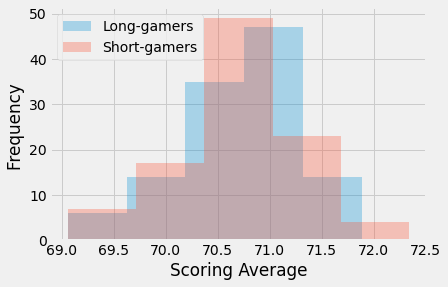

In [120]:
fig, ax = plt.subplots()
ax.hist(long_gamers_scoring,alpha=0.3,bins=5,label='Long-gamers') #density = True
ax.hist(short_gamers_scoring,alpha=0.3,bins=5,label='Short-gamers') #density = True
ax.set_xlabel('Scoring Average')
ax.set_ylabel('Frequency ')
ax.legend();

In [121]:
#null 1, the averages are equal

In [122]:
def welch_test_statistic(sample_1, sample_2):
    numerator = np.mean(sample_1) - np.mean(sample_2)
    denominator_sq = (np.var(sample_1) / len(sample_1)) + \
                        (np.var(sample_2) / len(sample_2))
    return numerator / np.sqrt(denominator_sq)

In [123]:
long_vs_short_test_stat = welch_test_statistic(long_gamers_scoring, short_gamers_scoring)
print("Welch Test Statistic: {:2.2f}".format(long_vs_short_test_stat))

Welch Test Statistic: -0.07


In [124]:
def welch_satterhwaithe_df(sample_1, sample_2):
    ss1 = len(sample_1)
    ss2 = len(sample_2)
    df = (
        ((np.var(sample_1)/ss1 + np.var(sample_2)/ss2)**(2.0)) / 
        ((np.var(sample_1)/ss1)**(2.0)/(ss1 - 1) + (np.var(sample_2)/ss2)**(2.0)/(ss2 - 1))
    )
    return df

In [125]:
deg_free = welch_satterhwaithe_df(long_gamers_scoring, short_gamers_scoring)
print("Degrees of Freedom for Welch's Test: {:2.2f}".format(deg_free))

Degrees of Freedom for Welch's Test: 202.28


In [126]:
#choose alpha .05

In [127]:
t_dist = stats.t(deg_free)
p_different_means = t_dist.cdf(long_vs_short_test_stat) + (1 - t_dist.cdf(-long_vs_short_test_stat))
print("p-value for different average score: {:2.2f}".format(p_different_means))

p-value for different average score: 0.95


In [128]:
#fail to reject null hypothesis

In [129]:
drivers_bool = golf_df['tee_strokes_gained'] > 0
drivers = golf_df[drivers_bool]
drivers

,name,tee_rank,tee_strokes_gained,approach_rank,approach_strokes_gained,chip_rank,chip_strokes_gained,putt_rank,putt_strokes_gained,scoring_average,LONG_GAME_RANK,LONG_STROKES_GAINED,SHORT_GAME_RANK,SHORT_STROKES_GAINED
0,Rory McIlroy,1,1.195,12,0.633,19,0.297,24,0.425,69.057,1.0,0.9140,12.0,0.3610
1,Jhonattan Vegas,2,0.753,60,0.219,154,-0.190,135,-0.156,70.765,14.0,0.4860,152.0,-0.1730
2,Bubba Watson,3,0.743,120,-0.052,124,-0.067,167,-0.344,70.710,30.0,0.3455,162.0,-0.2055
3,Dustin Johnson,4,0.703,47,0.288,38,0.234,74,0.096,69.895,13.0,0.4955,50.0,0.1650
4,Jon Rahm,5,0.692,34,0.405,78,0.073,36,0.336,69.618,11.0,0.5485,39.0,0.2045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,Sangmoon Bae,108,0.020,180,-0.568,174,-0.302,49,0.217,71.762,161.0,-0.2740,121.0,-0.0425
108,Russell Knox,109,0.013,18,0.585,58,0.129,142,-0.176,70.521,39.0,0.2990,114.0,-0.0235
109,Chase Wright,109,0.013,123,-0.069,178,-0.313,27,0.379,71.233,123.0,-0.0280,87.0,0.0330
110,Nick Watney,111,0.010,96,0.071,88,0.040,96,0.012,70.908,100.0,0.0405,90.0,0.0260


In [130]:
putters_bool = golf_df['putt_strokes_gained'] > 0
putters = golf_df[putters_bool]
putters

,name,tee_rank,tee_strokes_gained,approach_rank,approach_strokes_gained,chip_rank,chip_strokes_gained,putt_rank,putt_strokes_gained,scoring_average,LONG_GAME_RANK,LONG_STROKES_GAINED,SHORT_GAME_RANK,SHORT_STROKES_GAINED
0,Rory McIlroy,1,1.195,12,0.633,19,0.297,24,0.425,69.057,1.0,0.9140,12.0,0.3610
3,Dustin Johnson,4,0.703,47,0.288,38,0.234,74,0.096,69.895,13.0,0.4955,50.0,0.1650
4,Jon Rahm,5,0.692,34,0.405,78,0.073,36,0.336,69.618,11.0,0.5485,39.0,0.2045
11,Tommy Fleetwood,12,0.545,55,0.235,15,0.329,55,0.169,69.729,23.0,0.3900,28.0,0.2490
12,Jason Day,13,0.535,127,-0.083,100,0.025,30,0.356,70.212,45.0,0.2260,43.0,0.1905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,Chris Stroud,182,-0.557,147,-0.229,94,0.035,94,0.022,71.644,176.0,-0.3930,89.0,0.0285
182,Scott Langley,183,-0.593,176,-0.483,47,0.179,65,0.130,71.605,184.0,-0.5380,52.5,0.1545
183,Andrew Putnam,184,-0.639,32,0.414,83,0.061,5,0.700,70.644,138.0,-0.1125,10.0,0.3805
184,Freddie Jacobson,184,-0.639,138,-0.151,152,-0.178,64,0.142,71.953,177.0,-0.3950,110.0,-0.0180


In [131]:
drivers_scoring = drivers['scoring_average']
putters_scoring = putters['scoring_average']
drivers_mean = drivers_scoring.mean()
putters_mean = putters_scoring.mean()

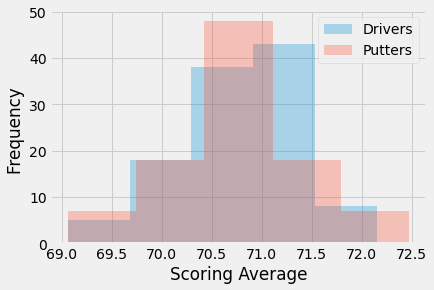

In [132]:
fig, ax = plt.subplots()
ax.hist(drivers_scoring,alpha=0.3,bins=5,label='Drivers') #density = True
ax.hist(putters_scoring,alpha=0.3,bins=5,label='Putters') #density = True
ax.set_xlabel('Scoring Average')
ax.set_ylabel('Frequency ')
ax.legend();

In [133]:
#null 1 the means are equal

In [134]:
drive_vs_putt_test_stat = welch_test_statistic(drivers_scoring, putters_scoring)
print("Welch Test Statistic: {:2.2f}".format(drive_vs_putt_test_stat))

Welch Test Statistic: -0.07


In [135]:
deg_free2 = welch_satterhwaithe_df(drivers_scoring, putters_scoring)
print("Degrees of Freedom for Welch's Test: {:2.2f}".format(deg_free2))

Degrees of Freedom for Welch's Test: 197.49


In [136]:
t_dist = stats.t(deg_free2)
p_different_means = t_dist.cdf(drive_vs_putt_test_stat) + (1 - t_dist.cdf(-drive_vs_putt_test_stat))
print("p-value for different average score: {:2.2f}".format(p_different_means))

p-value for different average score: 0.94


In [137]:
#fail to reject null hypothesis